# 
Se estudiará si es posible encontrar algún modelo que se ajuste a cada uno de los casos a estudiar, desde un punto de vista de estadística convencional. Lo cual requerirá previamente analizar que operaciones de preprocesamiento permiten alcanzar la estacionariedad en cada una de ellas. Se cuenta con cuatro series de tiempo alrededor de los puntos:
- 100s.
- 130s.
- 160s.
- 176s.

Cada serie de tiempo ha sido preparada en `data_explorer.ipynb`.

## Librerías necesarias

In [2]:
# Librerías principales
import os
import numpy as np
import pandas as pd

# Herramientas para graficar
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import Grid
from matplotlib import ticker
%matplotlib inline

# Estadística
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from scipy import signal

# Versiones de librerías
print("".join(f"{x[0]}: {x[1]}\n" for x in [
    ("Numpy",np.__version__),
    ("Pandas",pd.__version__),
    ("Statsmodel",sm.__version__),
]))

Numpy: 1.23.1
Pandas: 1.4.3
Statsmodel: 0.13.2



## Carga del dataset
Se levantan las series de tiempo. Se las agrupa en una lista.

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# path = '/content/drive/MyDrive/Colab Notebooks/tsa/data'
path = './data'
files_name = ['dataset_100s.csv', 'dataset_130s.csv', 'dataset_160s.csv', 'dataset_176s.csv']
ts_all = []
# Exportación a csv de cada dataframe
for i in range(len(files_name)):
    ts = pd.read_csv(os.path.join(path, files_name[i]), index_col='Time')
    ts = pd.Series(ts['Bearing 1'])
    ts_all.append(ts)


## Funciones útiles

In [5]:
# Diferenciación a un paso
def diference(ts, n):
    '''
    Función para diferenciar a un paso una serie de tiempo, n veces
    '''
    ts_a = ts
    if n == 1:
        return ts_a - ts_a.shift(1)
    else:
        for i in range(n):
            diff_ts = ts_a - ts_a.shift(1)
            ts_a = diff_ts
        return diff_ts

## Descripción general
Se empieza por mostrar las cuatro señales.

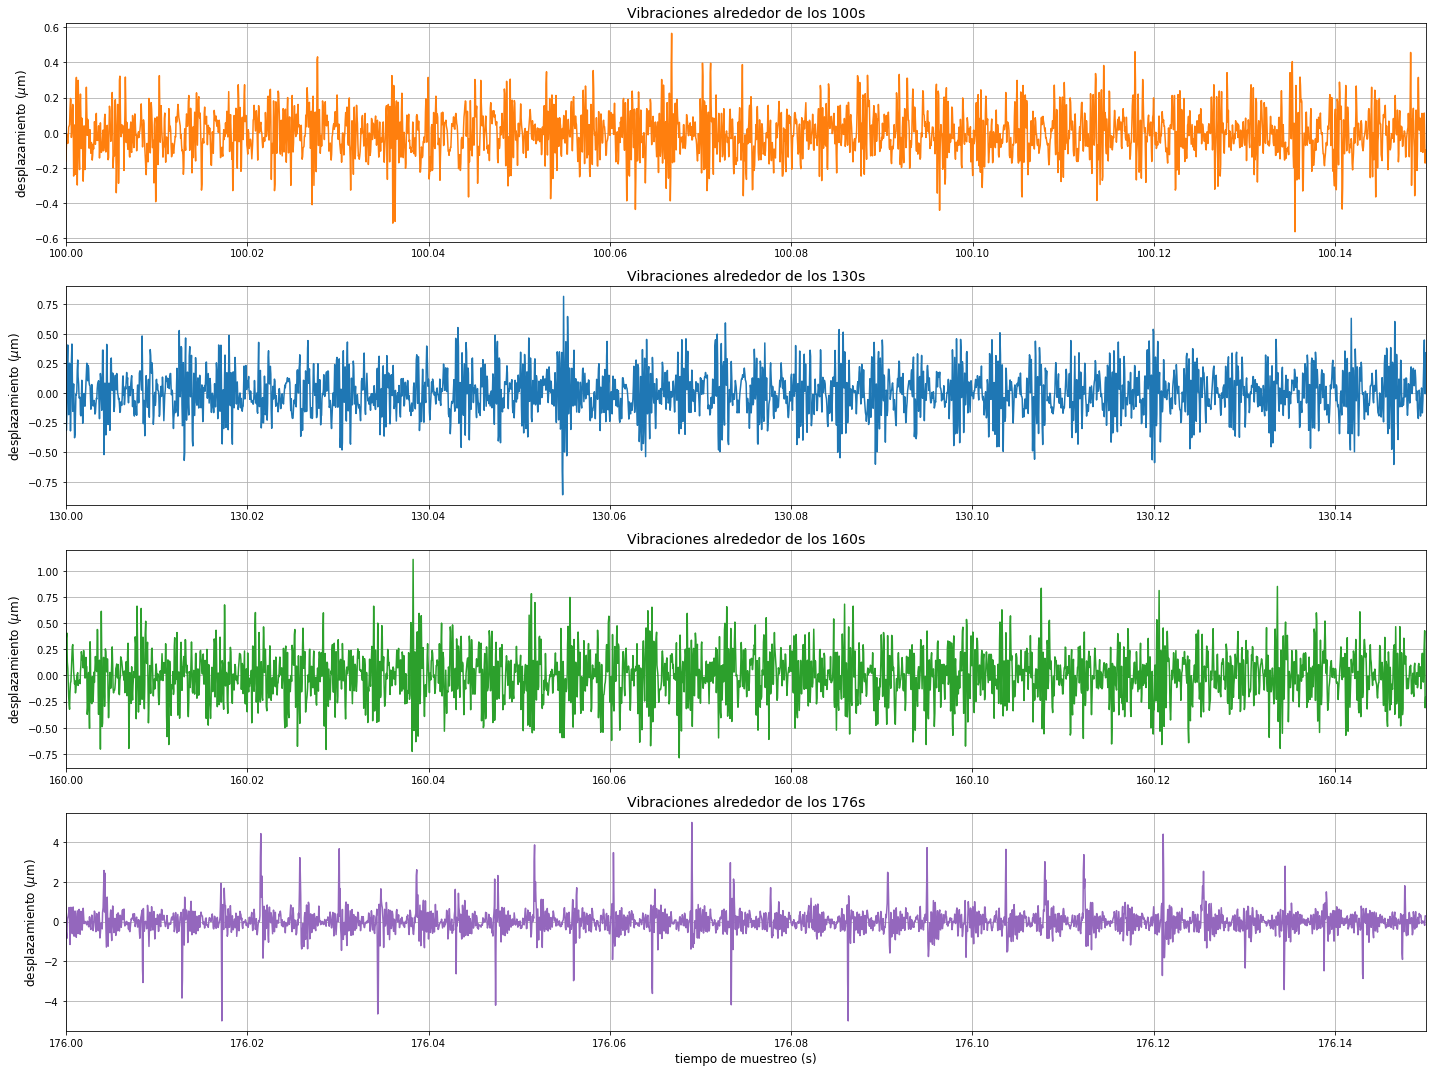

In [38]:
point = [100, 130, 160, 176]
colors = ['tab:orange', 'tab:blue', 'tab:green', 'tab:purple']

g=0
fig, axs = plt.subplots(4, 1, figsize=(20, 15))

for i in range(len(point)):
    axs[i].plot(ts_all[g], color=colors[g])
    axs[i].set_xlim(ts_all[g].index[0], ts_all[g].index[-1])
    axs[i].grid(True)
    axs[i].set_ylabel('desplazamiento ($\mu$m)', fontsize=12)
    axs[i].set_title(f'Vibraciones alrededor de los {int(point[g])}s', fontsize=14)
    g +=1

plt.xlabel('tiempo de muestreo (s)', fontsize=12)
plt.tight_layout()

De los gráficos puede decirse que cada serie:
- Todas las señales se mueven en torno al cero. No se visualiza alguna posible tendencia, como tampoco cambios en el tiempo de la varianza.
- Posible aletoriedad de amplitud, frecuencia y fase.
- Posible comportamiento cíclico.

Se continua con las autocorrelaciones y las autocorrelaciones parciales.

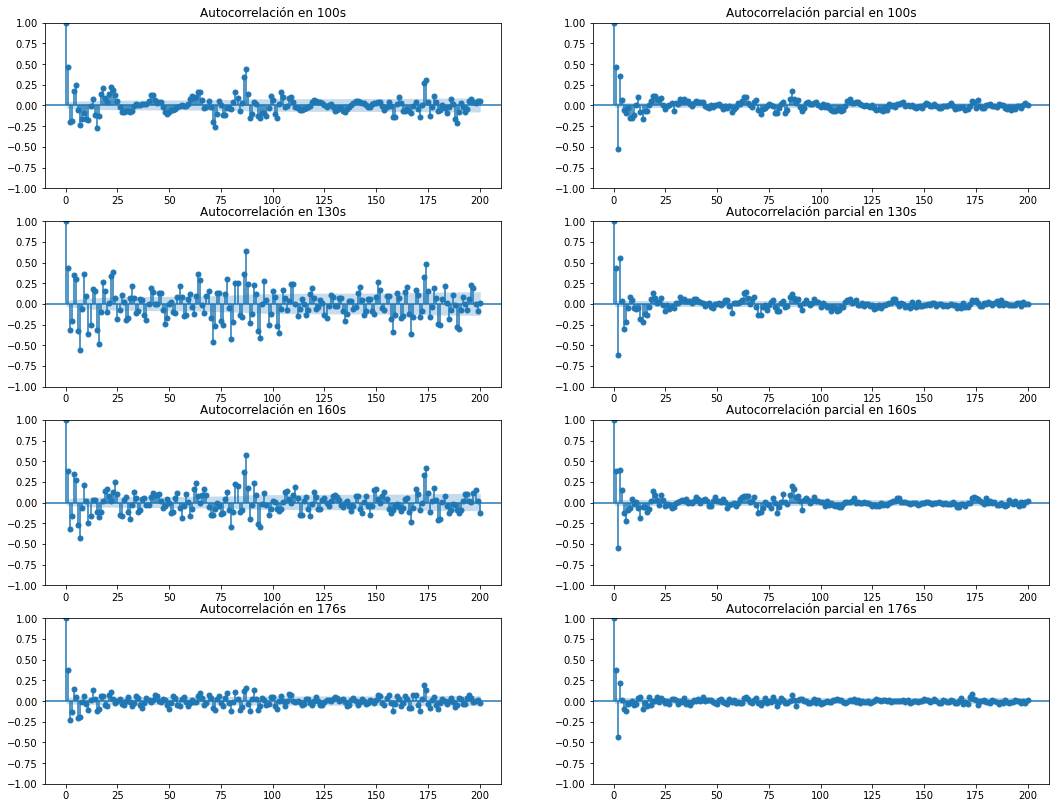

In [41]:
point = [100, 130, 160, 176]
lags = [200, 200, 200, 200]

# Definición del subplot
fig, axs = plt.subplots(4, 2, figsize=(18, 14))

k=0
# Generación de imágenes e histogramas
for i in range(4):
    for j in range(2):
        if j == 0:
            plot_acf(ts_all[k], ax=axs[i,j], lags=lags[k], title=f'Autocorrelación en {int(point[k])}s')
        else: 
            plot_pacf(ts_all[k], ax=axs[i,j], lags=lags[k], title=f'Autocorrelación parcial en {int(point[k])}s', method='ywm')
    k+=1

plt.show()


En todo los casos se comparte que:
- No se visualiza un comportamiento claro de esatacionariedad. 
- Se expresa un comportamiento cíclico. 
  
En cada caso, dichos fenómenos se expresan con diferente intensidad. Por lo demás, el preprocesamiento se limitará a diferenciar cada una de las series. 

## Punto 100s
### Características
Se empieza por hacer los tests de Dickey-Fuller y KPSS para ver qué arrojan. 

In [8]:
ts_100 = ts_all[0]
print(f'Test de Dickey-Fuller: \n {adfuller(ts_100)}')
print(f'Test KPSS: \n {kpss(ts_100)}')

Test de Dickey-Fuller: 
 (-8.823533187895707, 1.849629317178818e-14, 29, 2970, {'1%': -3.4325536905242227, '5%': -2.862513646507894, '10%': -2.567288298246211}, -6579.803154727546)
Test KPSS: 
 (0.06538868796500039, 0.1, 20, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


c:\Users\Carlo\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Por el momento los tests arrojan estacionariedad. Resta ajustar las autocorrelaciones. Se realiza la diferenciación a un paso

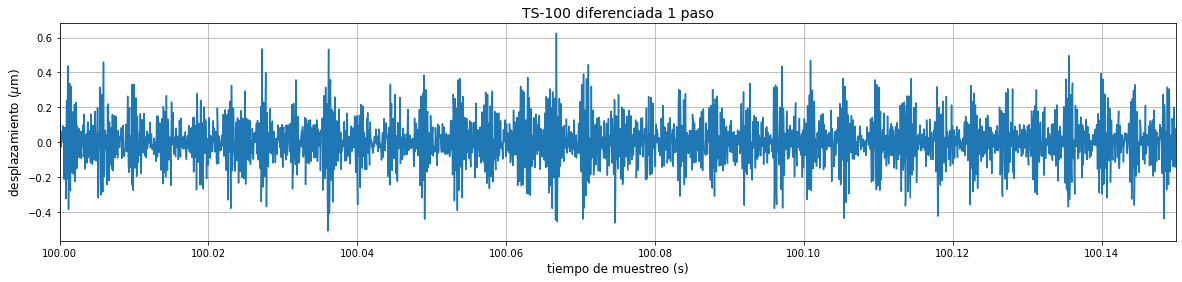

In [9]:
diff_ts_100_1 = diference(ts_100,1)

plt.figure(figsize=(20,4))

plt.plot(diff_ts_100_1.index, diff_ts_100_1)
plt.xlim(diff_ts_100_1.index[0], diff_ts_100_1.index[-1])
plt.grid()
plt.xlabel('tiempo de muestreo (s)', fontsize=12)
plt.ylabel('desplazamiento ($\mu$m)', fontsize=12)
plt.title(f'TS-100 diferenciada 1 paso', fontsize=14)

plt.show()

Estado de las autocorrelaciones luego de la primera diferenciación

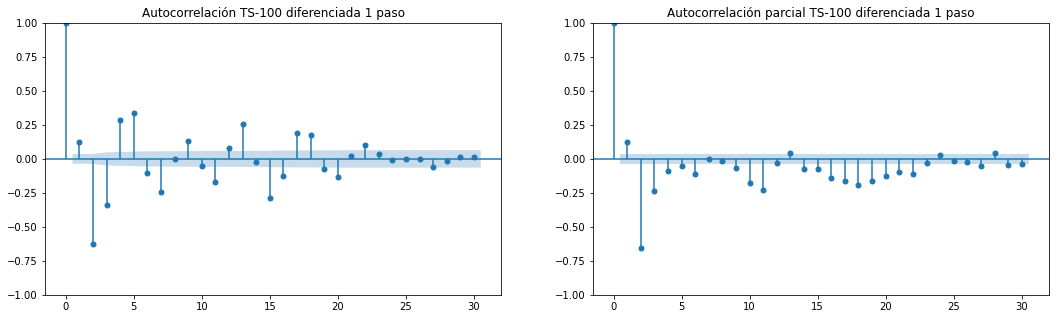

In [10]:
fig = plt.figure(figsize=(18, 5))

ax1=plt.subplot(121)
plot_acf(diff_ts_100_1.dropna(), ax=ax1, lags=30, title=f'Autocorrelación TS-100 diferenciada 1 paso')

ax2=plt.subplot(122)
plot_pacf(diff_ts_100_1.dropna(), ax=ax2, lags=30, title=f'Autocorrelación parcial TS-100 diferenciada 1 paso', method='ywm')

plt.show()

No se presentan mejoras. Gráfico de periodograma a la serie original TS-100.

In [11]:
# Cálculo de periodograma
fr_100, A_100 = signal.periodogram(ts_100,len(ts_100))

Se normaliza para mostrar en gráfico, a los valores según a la mitad de la frecuencia de muestreo. Resulta válido para el resto del trabajo.

In [12]:
# Normalización a frecuencia de muestreo (el valor original está expresado en miles)
# Frecuencia de muestreo del ensayo
sr = 20e3

arr_sr = np.linspace(0, 10000, len(fr_100), dtype='float32')

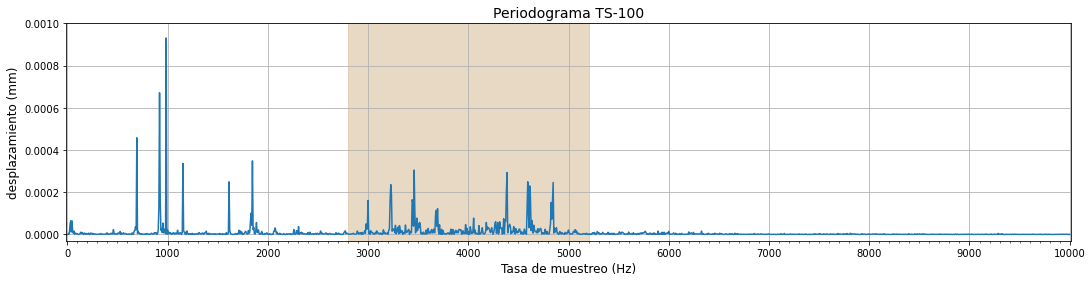

In [13]:
fig, ax  = plt.subplots(1,1, figsize=(18, 4))

ax.plot(arr_sr, A_100, 'C0')
ax.set_xlim(arr_sr[0]-10, arr_sr[-1]+10)
ax.set_ylim(-0.00003, 0.001)
ax.grid()
ax.fill_betweenx([-0.00003, 0.001],arr_sr[420], arr_sr[780], color ='tan', alpha = 0.5)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(100))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.set_xlabel('Tasa de muestreo (Hz)', fontsize=12)
ax.set_ylabel('desplazamiento (mm)', fontsize=12)
ax.set_title(f'Periodograma TS-100', fontsize=14)

plt.show()

Además de las frecuencias predominantes, se expresa una modulación (zona sombreada).

### Prueba de modelos

In [14]:
arima = ARIMA(ts_100, order=(2,0,3))
arima_fit = arima.fit()
arima_fit.summary()

c:\Users\Carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Bearing 1   No. Observations:                 3000
Model:                 ARIMA(2, 0, 3)   Log Likelihood                3082.286
Date:                Fri, 14 Oct 2022   AIC                          -6150.571
Time:                        18:49:49   BIC                          -6108.527
Sample:                             0   HQIC                         -6135.448
                               - 3000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.003     -1.263      0.207      -0.009       0.002
ar.L1          0.2047      0.020     10.256      0.000       0.166       0.244
ar.L2         -0.8091      0.018    -44.607      0.000      -0.845      -0.774
ma.L1          0.6611      0.028     23.731      0.000       0.606       0.716
ma.L2          0.6761      0.032     20.999      0.000       0.613       0.739
ma.L3          0.3833      0.024     16.017      0.000       0.336       0.430
sigma2         0.0075      0.000     49.060      0.000       0.007       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.95   Jarque-Bera (JB):               221.47
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.00
Prob(H) (two-sided):                  0.94   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Residuos

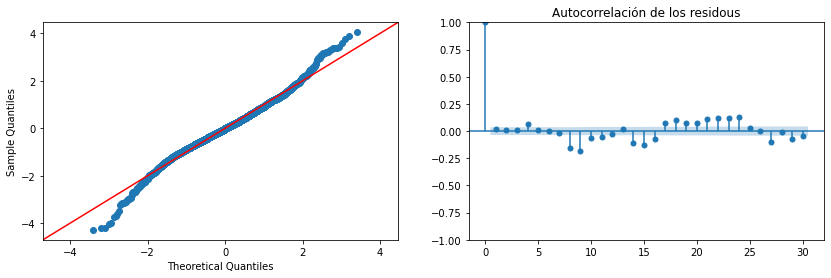

In [15]:
resid = arima_fit.resid

fig = plt.figure(figsize=(14, 4))

ax1=plt.subplot(121)
sm.qqplot((resid-resid.mean())/resid.std(), ax=ax1, line='45')

ax2=plt.subplot(122)
plot_acf(resid, ax=ax2, lags=30, title=f'Autocorrelación de los residous')

plt.show()

## Punto 130s
### Características
Se empieza por hacer los tests de Dickey-Fuller y KPSS para ver qué arrojan. 

In [16]:
ts_130 = ts_all[1]
print(f'Test de Dickey-Fuller: \n {adfuller(ts_130)}')
print(f'Test KPSS: \n {kpss(ts_130)}')

Test de Dickey-Fuller: 
 (-13.467182904470677, 3.438168128170218e-25, 28, 2972, {'1%': -3.4325522062723506, '5%': -2.862512990970051, '10%': -2.5672879492445415}, -5891.271086160614)
Test KPSS: 
 (0.05652695452066788, 0.1, 26, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


c:\Users\Carlo\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Por el momento los tests arrojan estacionariedad. Resta ajustar las autocorrelaciones. Se realiza la diferenciación a un paso

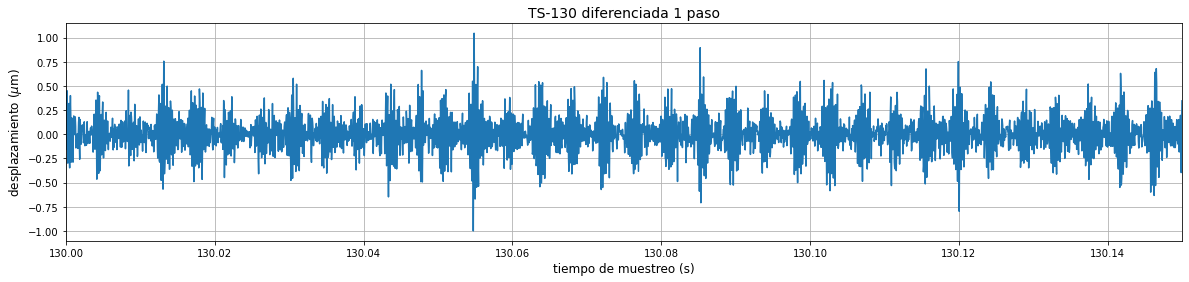

In [17]:
diff_ts_130_1 = diference(ts_130,1)

plt.figure(figsize=(20,4))

plt.plot(diff_ts_130_1.index, diff_ts_130_1)
plt.xlim(diff_ts_130_1.index[0], diff_ts_130_1.index[-1])
plt.grid()
plt.xlabel('tiempo de muestreo (s)', fontsize=12)
plt.ylabel('desplazamiento ($\mu$m)', fontsize=12)
plt.title(f'TS-130 diferenciada 1 paso', fontsize=14)

plt.show()

Estado de las autocorrelaciones luego de la primera diferenciación.

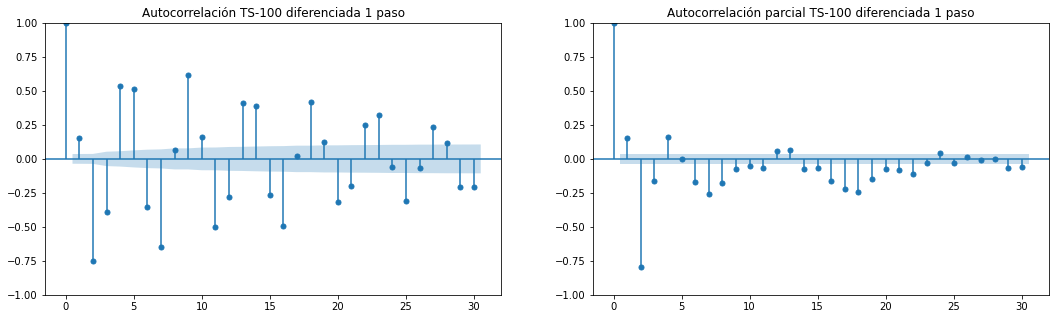

In [18]:
fig = plt.figure(figsize=(18, 5))

ax1=plt.subplot(121)
plot_acf(diff_ts_130_1.dropna(), ax=ax1, lags=30, title=f'Autocorrelación TS-100 diferenciada 1 paso')

ax2=plt.subplot(122)
plot_pacf(diff_ts_130_1.dropna(), ax=ax2, lags=30, title=f'Autocorrelación parcial TS-100 diferenciada 1 paso', method='ywm')

plt.show()

Gráfico de periodograma a la serie original TS-130.

In [19]:
# Cálculo de periodograma
fr_130, A_130 = signal.periodogram(ts_130,len(ts_130))

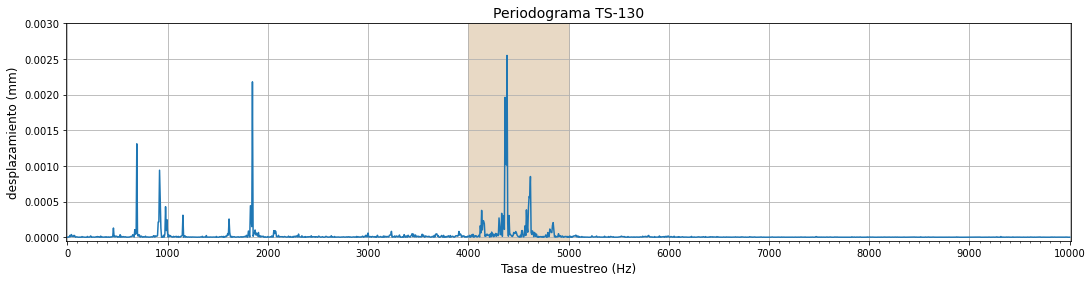

In [20]:
fig, ax  = plt.subplots(1,1, figsize=(18, 4))

ax.plot(arr_sr, A_130, 'C0')
ax.set_xlim(arr_sr[0]-10, arr_sr[-1]+10)
ax.set_ylim(-0.00005, 0.003)
ax.grid()
ax.fill_betweenx([-0.00005, 0.003],arr_sr[600], arr_sr[750], color ='tan', alpha = 0.5)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(100))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.set_xlabel('Tasa de muestreo (Hz)', fontsize=12)
ax.set_ylabel('desplazamiento (mm)', fontsize=12)
ax.set_title(f'Periodograma TS-130', fontsize=14)

plt.show()

Cambios producidos:
- Incrmento de amplitudes.
- Incremento de frecuencias predominantes.
- La modulación se ha estrechado en frecuencias y se volvió asimétrica.

### Probando modelos

In [21]:
arima = ARIMA(ts_130, order=(3,0,4))
arima_fit = arima.fit()
arima_fit.summary()

c:\Users\Carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Bearing 1   No. Observations:                 3001
Model:                 ARIMA(3, 0, 4)   Log Likelihood                2682.562
Date:                Fri, 14 Oct 2022   AIC                          -5347.123
Time:                        18:49:53   BIC                          -5293.063
Sample:                             0   HQIC                         -5327.678
                               - 3001                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.004     -0.033      0.974      -0.009       0.009
ar.L1          0.7821      0.041     18.976      0.000       0.701       0.863
ar.L2         -1.0897      0.015    -70.598      0.000      -1.120      -1.059
ar.L3          0.3916      0.041      9.569      0.000       0.311       0.472
ma.L1          0.2009      0.042      4.727      0.000       0.118       0.284
ma.L2          0.5603      0.028     20.187      0.000       0.506       0.615
ma.L3          0.3103      0.034      9.075      0.000       0.243       0.377
ma.L4          0.1672      0.027      6.105      0.000       0.114       0.221
sigma2         0.0098      0.000     52.006      0.000       0.009       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               464.76
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -0.09
Prob(H) (two-sided):                  0.64   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Residuos

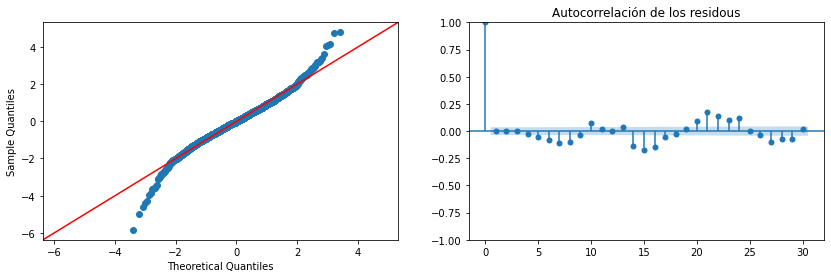

In [22]:
resid = arima_fit.resid

fig = plt.figure(figsize=(14, 4))

ax1=plt.subplot(121)
sm.qqplot((resid-resid.mean())/resid.std(), ax=ax1, line='45')

ax2=plt.subplot(122)
plot_acf(resid, ax=ax2, lags=30, title=f'Autocorrelación de los residous')

plt.show()

## Punto 160s
### Características
Se empieza por hacer los tests de Dickey-Fuller y KPSS para ver qué arrojan. 

In [23]:
ts_160 = ts_all[2]
print(f'Test de Dickey-Fuller: \n {adfuller(ts_160)}')
print(f'Test KPSS: \n {kpss(ts_160)}')

Test de Dickey-Fuller: 
 (-12.232078160373545, 1.0480523317973587e-22, 28, 2972, {'1%': -3.4325522062723506, '5%': -2.862512990970051, '10%': -2.5672879492445415}, -3173.5184582167503)
Test KPSS: 
 (0.06864149743758444, 0.1, 25, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


c:\Users\Carlo\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Por el momento los tests arrojan estacionariedad. Resta ajustar las autocorrelaciones. Se realiza la diferenciación a un paso

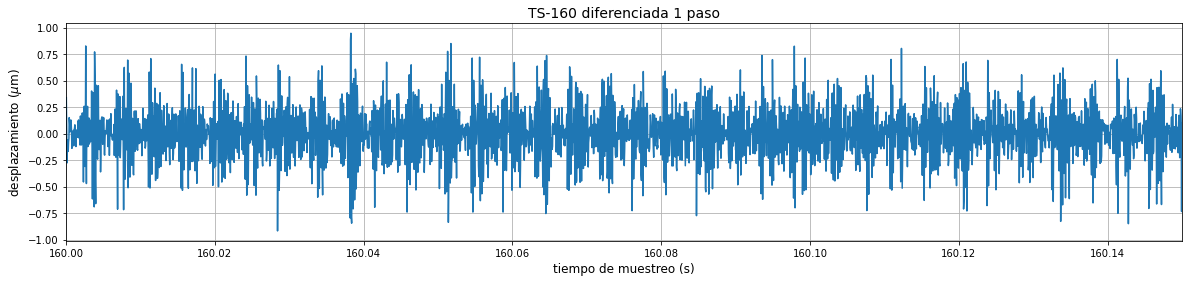

In [24]:
diff_ts_160_1 = diference(ts_160,1)

plt.figure(figsize=(20,4))

plt.plot(diff_ts_160_1.index, diff_ts_160_1)
plt.xlim(diff_ts_160_1.index[0], diff_ts_160_1.index[-1])
plt.grid()
plt.xlabel('tiempo de muestreo (s)', fontsize=12)
plt.ylabel('desplazamiento ($\mu$m)', fontsize=12)
plt.title(f'TS-160 diferenciada 1 paso', fontsize=14)

plt.show()

Estado de las autocorrelaciones

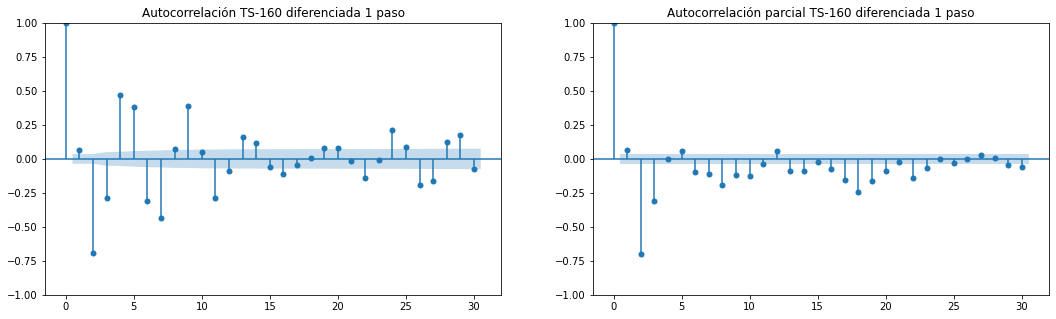

In [25]:
fig = plt.figure(figsize=(18, 5))

ax1=plt.subplot(121)
plot_acf(diff_ts_160_1.dropna(), ax=ax1, lags=30, title=f'Autocorrelación TS-160 diferenciada 1 paso')

ax2=plt.subplot(122)
plot_pacf(diff_ts_160_1.dropna(), ax=ax2, lags=30, title=f'Autocorrelación parcial TS-160 diferenciada 1 paso', method='ywm')

plt.show()

Gráfico de periodograma a TS-160

In [26]:
# Cálculo de periodograma
fr_160, A_160 = signal.periodogram(ts_160,len(ts_160))

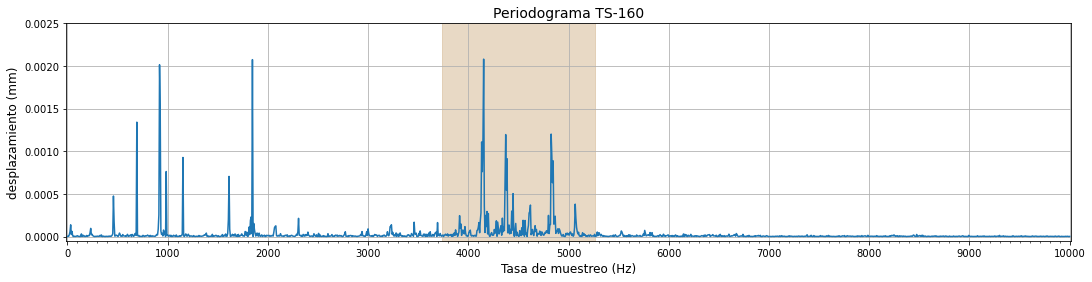

In [28]:

fig, ax  = plt.subplots(1,1, figsize=(18, 4))

ax.plot(arr_sr, A_160, 'C0')
ax.set_xlim(arr_sr[0]-10, arr_sr[-1]+10)
ax.set_ylim(-0.00005, 0.0025)
ax.grid()
ax.fill_betweenx([-0.00005, 0.0025],arr_sr[560], arr_sr[790], color ='tan', alpha = 0.5)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(100))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.set_xlabel('Tasa de muestreo (Hz)', fontsize=12)
ax.set_ylabel('desplazamiento (mm)', fontsize=12)
ax.set_title(f'Periodograma TS-160', fontsize=14)

plt.show()

### Probando modelos

In [29]:
arima = ARIMA(ts_160, order=(3,0,4))
arima_fit = arima.fit()
arima_fit.summary()

c:\Users\Carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Bearing 1   No. Observations:                 3001
Model:                 ARIMA(3, 0, 4)   Log Likelihood                1417.436
Date:                Fri, 14 Oct 2022   AIC                          -2816.873
Time:                        18:49:57   BIC                          -2762.813
Sample:                             0   HQIC                         -2797.428
                               - 3001                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.005     -0.079      0.937      -0.011       0.010
ar.L1          0.7897      0.056     14.005      0.000       0.679       0.900
ar.L2         -1.0051      0.027    -37.544      0.000      -1.058      -0.953
ar.L3          0.3393      0.055      6.135      0.000       0.231       0.448
ma.L1         -0.0622      0.058     -1.076      0.282      -0.175       0.051
ma.L2          0.3977      0.025     15.656      0.000       0.348       0.448
ma.L3          0.2401      0.035      6.792      0.000       0.171       0.309
ma.L4          0.1295      0.034      3.807      0.000       0.063       0.196
sigma2         0.0228      0.001     44.247      0.000       0.022       0.024
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               113.42
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.15
Prob(H) (two-sided):                  0.53   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Residuos

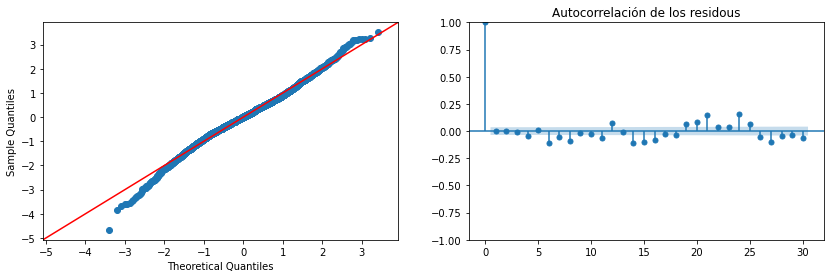

In [30]:
resid = arima_fit.resid

fig = plt.figure(figsize=(14, 4))

ax1=plt.subplot(121)
sm.qqplot((resid-resid.mean())/resid.std(), ax=ax1, line='45')

ax2=plt.subplot(122)
plot_acf(resid, ax=ax2, lags=30, title=f'Autocorrelación de los residous')

plt.show()

## Punto 176s
### Características
Se empieza por hacer los tests de Dickey-Fuller y KPSS para ver qué arrojan. 


In [31]:
ts_176 = ts_all[3]
print(f'Test de Dickey-Fuller: \n {adfuller(ts_176)}')
print(f'Test KPSS: \n {kpss(ts_176)}')

Test de Dickey-Fuller: 
 (-10.998946431568449, 6.7586940190652e-20, 27, 2973, {'1%': -3.432551464895929, '5%': -2.8625126635320393, '10%': -2.567287774919901}, 4411.854809275949)
Test KPSS: 
 (0.04222684854823708, 0.1, 9, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


c:\Users\Carlo\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Por el momento los tests arrojan estacionariedad. Resta ajustar las autocorrelaciones. Se realiza la diferenciación a un paso.

Text(0.5, 1.0, 'TS-176 diferenciada 1 paso')

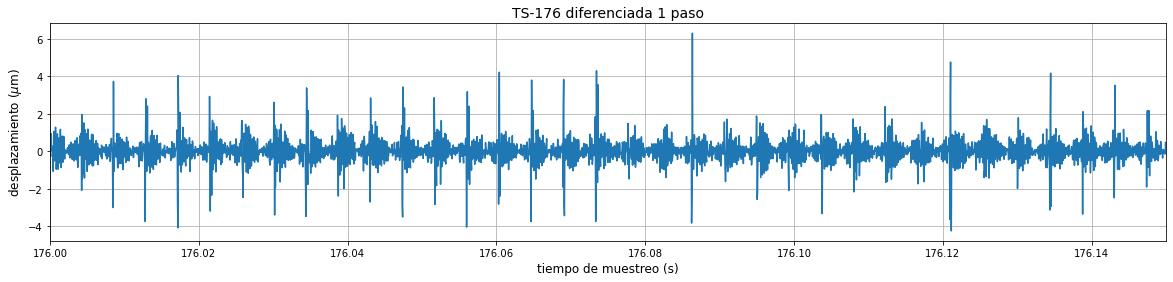

In [32]:
diff_ts_176_1 = diference(ts_176,1)

plt.figure(figsize=(20,4))

plt.plot(diff_ts_176_1.index, diff_ts_176_1)
plt.xlim(diff_ts_176_1.index[0], diff_ts_176_1.index[-1])
plt.grid()
plt.xlabel('tiempo de muestreo (s)', fontsize=12)
plt.ylabel('desplazamiento ($\mu$m)', fontsize=12)
plt.title(f'TS-176 diferenciada 1 paso', fontsize=14)

Estado de las autocorrelaciones luego de la primera diferenciación.

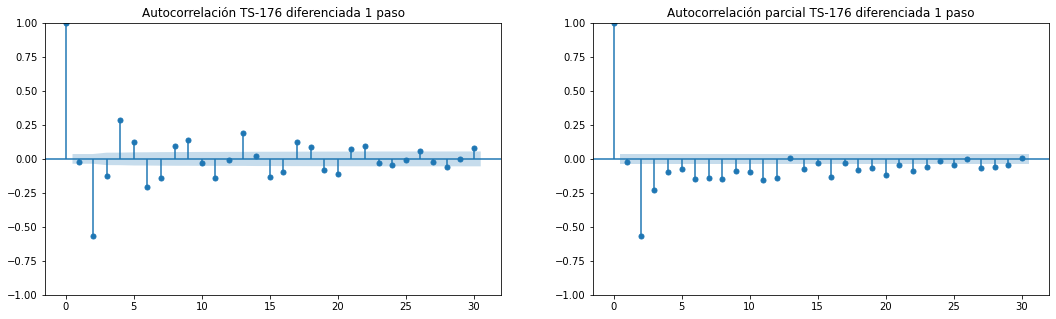

In [33]:
fig = plt.figure(figsize=(18, 5))

ax1=plt.subplot(121)
plot_acf(diff_ts_176_1.dropna(), ax=ax1, lags=30, title=f'Autocorrelación TS-176 diferenciada 1 paso')

ax2=plt.subplot(122)
plot_pacf(diff_ts_176_1.dropna(), ax=ax2, lags=30, title=f'Autocorrelación parcial TS-176 diferenciada 1 paso', method='ywm')

plt.show()

Gráfico de periodograma a TS-176

In [34]:
# Cálculo de periodograma
fr_176, A_176 = signal.periodogram(ts_176,len(ts_176))

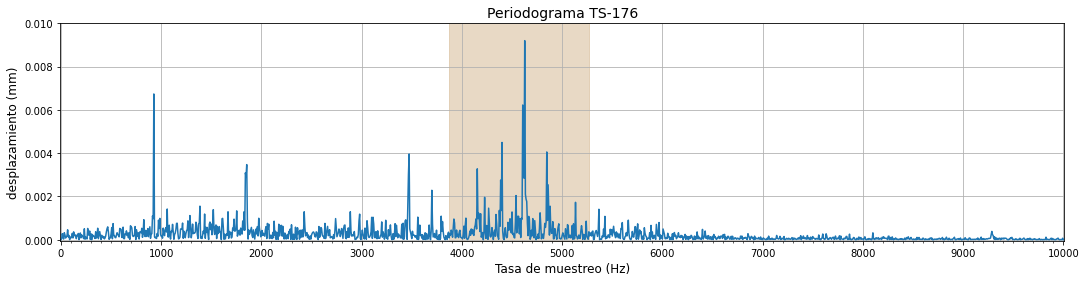

In [35]:

fig, ax  = plt.subplots(1,1, figsize=(18, 4))

ax.plot(arr_sr, A_176, 'C0')
ax.set_xlim(arr_sr[0]-10, arr_sr[-1]+10)
ax.set_ylim(-0.00005, 0.01)
ax.grid()
ax.fill_betweenx([-0.00005, 0.01],arr_sr[580], arr_sr[790], color ='tan', alpha = 0.5)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(100))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.set_xlabel('Tasa de muestreo (Hz)', fontsize=12)
ax.set_ylabel('desplazamiento (mm)', fontsize=12)
ax.set_title(f'Periodograma TS-176', fontsize=14)

plt.show()

Puntos destacados:
- Mayor presencia de ruido.
- Incremento de la amplitud
- Menos frecuencias predominantes.
- Modulación en la zona sombreada. Resta evaluar cómo se vería con el ruido filtrado.

### Probando modelos

In [36]:
arima = ARIMA(ts_176, order=(3,0,4))
arima_fit = arima.fit()
arima_fit.summary()

c:\Users\Carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Bearing 1   No. Observations:                 3001
Model:                 ARIMA(3, 0, 4)   Log Likelihood               -2249.077
Date:                Fri, 14 Oct 2022   AIC                           4516.154
Time:                        18:50:01   BIC                           4570.215
Sample:                             0   HQIC                          4535.599
                               - 3001                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0087      0.009      0.948      0.343      -0.009       0.027
ar.L1          1.0968      0.050     21.874      0.000       0.999       1.195
ar.L2         -1.0697      0.036    -29.648      0.000      -1.140      -0.999
ar.L3          0.7757      0.038     20.635      0.000       0.702       0.849
ma.L1         -0.5197      0.051    -10.237      0.000      -0.619      -0.420
ma.L2          0.2631      0.035      7.549      0.000       0.195       0.331
ma.L3         -0.1671      0.031     -5.470      0.000      -0.227      -0.107
ma.L4         -0.3979      0.024    -16.509      0.000      -0.445      -0.351
sigma2         0.2621      0.003     97.930      0.000       0.257       0.267
===================================================================================
Ljung-Box (L1) (Q):                   2.28   Jarque-Bera (JB):             24168.67
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Residuos

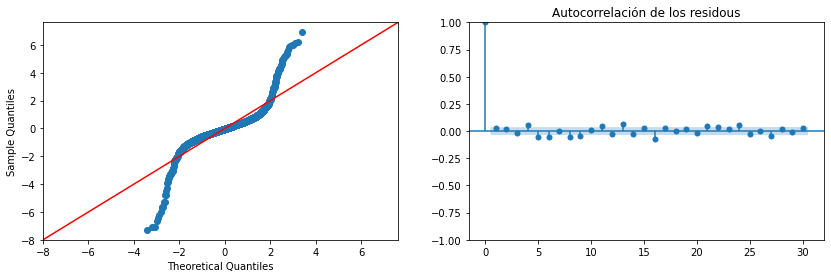

In [37]:
resid = arima_fit.resid

fig = plt.figure(figsize=(14, 4))

ax1=plt.subplot(121)
sm.qqplot((resid-resid.mean())/resid.std(), ax=ax1, line='45')

ax2=plt.subplot(122)
plot_acf(resid, ax=ax2, lags=30, title=f'Autocorrelación de los residous')

plt.show()

## Conclusiones
Se trata de señales que podría decirse que se basa en ruido. Este tipo de casos requiere ante todo un procesamiento de señales. Por otra parte, tanto la extracción de _features_ y modelado debe encararse desde un punto de vista de análisis espectral. El paso que sigue es modeloar redes tipo LSTM y comparar resultados.